## 1. 檢查 GPU
首先確定我們可以使用 GPU。我們可以使用 nvidia-smi 命令來檢查。如果出現錯誤訊息，請前往「編輯」->「筆記本設定」->「硬體加速器」，將其設置為 GPU，然後點擊保存。

In [1]:
!nvidia-smi

Fri Apr 26 13:44:20 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   44C    P8               9W /  70W |      0MiB / 15360MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

## 2. 訓練自己的 YOLOv8 keypoint 模型
### 2.1 安裝 ultralytics
Ultralytics YOLOv8 是由 Ultralytics 開發的 YOLO（You Only Look Once）物體檢測和圖像分割模型的最新版本。 在這份程式中，我們將介紹如何訓練一個 YOLOv8 關鍵點檢測模型。

In [2]:
!pip install ultralytics==8.0.196 -q

import ultralytics
ultralytics.checks()

Ultralytics YOLOv8.0.196 🚀 Python-3.10.12 torch-2.2.1+cu121 CUDA:0 (Tesla T4, 15102MiB)
Setup complete ✅ (2 CPUs, 12.7 GB RAM, 28.8/78.2 GB disk)


### 2.2 使用 Roboflow 匯入資料集

In [3]:
!pip install roboflow --q

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 74.1/74.1 kB 2.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 158.3/158.3 kB 13.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 178.7/178.7 kB 21.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.8/58.8 kB 8.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.1/49.1 MB 12.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.5/54.5 kB 7.5 MB/s eta 0:00:00


In [4]:
from roboflow import Roboflow
rf = Roboflow(api_key="8Z4ck3hgIdLkrbFet3Yj")
project = rf.workspace("yolo-zbpxw").project("screw-keypoint")
version = project.version(1)
dataset = version.download("yolov8")


loading Roboflow workspace...
loading Roboflow project...



Extracting Dataset Version Zip to screw-keypoint-1 in yolov8:: 100%|██████████| 165/165 [00:00<00:00, 3418.71it/s]


### 2.3 訓練模型

In [5]:
from ultralytics import YOLO

model = YOLO('yolov8n-pose.pt')

results = model.train(data=f"{dataset.location}/data.yaml", epochs=100, imgsz=640)

100%|██████████| 6.51M/6.51M [00:00<00:00, 112MB/s]
New https://pypi.org/project/ultralytics/8.2.2 available 😃 Update with 'pip install -U ultralytics'
Ultralytics YOLOv8.0.196 🚀 Python-3.10.12 torch-2.2.1+cu121 CUDA:0 (Tesla T4, 15102MiB)
engine/trainer: task=pose, mode=train, model=yolov8n-pose.pt, data=/content/screw-keypoint-1/data.yaml, epochs=100, patience=50, batch=16, imgsz=640, save=True, save_period=-1, cache=False, device=None, workers=8, project=None, name=None, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, show=False, save_txt=False, save_conf=False, save_crop=False, show_labels=True, show_conf=True, vid_stride=1, stream_bu

Your model will train for 100 epochs. After training, you can run test your model using an image from your test set.

## Test the Keypoint Detection Model

Let's test our keypoint detection model on an image:

In [8]:
model = YOLO('runs/pose/train/weights/last.pt')

import os
import random

random_file = f'{dataset.location}/valid/images/test-2_png.rf.d4e2d37d3029a45bf9f9c26b30469442.jpg'

results = model(os.path.join(f"{dataset.location}/valid/images", random_file))

print(results[0].keypoints)


image 1/1 /content/screw-keypoint-1/valid/images/test-2_png.rf.d4e2d37d3029a45bf9f9c26b30469442.jpg: 640x640 1 class1, 1 class2, 1 class3, 1 class4, 27.9ms
Speed: 8.9ms preprocess, 27.9ms inference, 14.7ms postprocess per image at shape (1, 3, 640, 640)


ultralytics.engine.results.Keypoints object with attributes:

conf: tensor([[0.9024, 0.9159],
        [0.8234, 0.7700],
        [0.9267, 0.9463],
        [0.9576, 0.9863]], device='cuda:0')
data: tensor([[[281.2741, 253.7119,   0.9024],
         [528.8397, 245.0125,   0.9159]],

        [[540.0336, 449.2006,   0.8234],
         [205.6295, 443.6773,   0.7700]],

        [[288.8135, 344.5841,   0.9267],
         [418.0272, 337.4523,   0.9463]],

        [[329.2474, 131.8630,   0.9576],
         [352.8284, 135.0173,   0.9863]]], device='cuda:0')
has_visible: True
orig_shape: (640, 640)
shape: torch.Size([4, 2, 3])
xy: tensor([[[281.2741, 253.7119],
         [528.8397, 245.0125]],

        [[540.0336, 449.2006],
         [205.6295, 443.6773]],

        [[288.8135, 344.5841],
         [418.0272, 337.4523]],

        [[329.2474, 131.8630],
         [352.8284, 135.0173]]], device='cuda:0')
xyn: tensor([[[0.4395, 0.3964],
         [0.8263, 0.3828]],

        [[0.8438, 0.7019],
         [0.3213

We can visualize our keypoints using the following code:

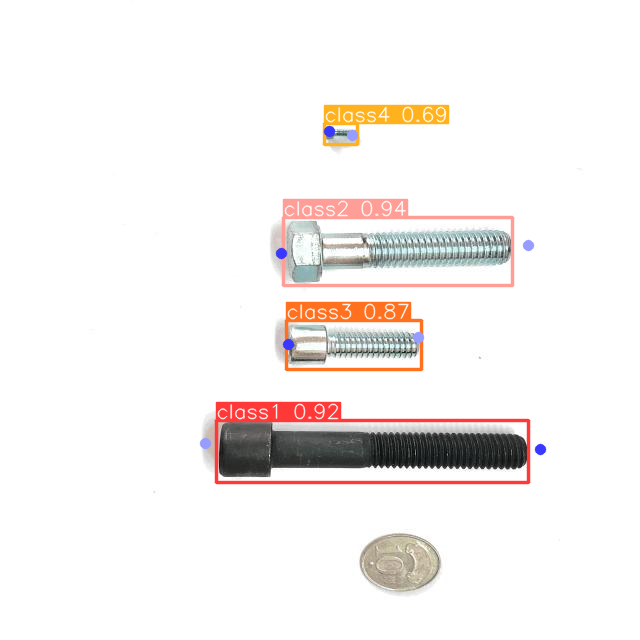

In [9]:
from PIL import Image

r = results[0]
im_array = r.plot()  # plot a BGR numpy array of predictions
im = Image.fromarray(im_array[..., ::-1])  # RGB PIL image
display(im)

## Reference
- [How to Train a Custom Ultralytics YOLOv8 Pose Estimation Model](https://blog.roboflow.com/train-a-custom-yolov8-pose-estimation-model/)